### This is a notebook to format your data for segmentation, run the images through the cloud instance of Mesmer, and then extract marker counts and morphological information from all the cells in your images

In [1]:
import threading
threading.activeCount()

8

In [2]:
import cProfile as profile
import pstats

In [44]:
# import required packages
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
import xarray as xr
from alpineer import io_utils, load_utils, image_utils

from ark.segmentation import marker_quantification, segmentation_utils
from ark.utils import (deepcell_service_utils, example_dataset,
                       plot_utils)

from deepcell.applications import Mesmer
from deepcell.datasets import multiplex_tissue
from pathlib import Path

from tensorflow.keras.models import load_model
from deepcell.utils.plot_utils import make_outline_overlay

from deepcell.utils.plot_utils import create_rgb_image
from matplotlib import pyplot as plt
import pathlib
from tqdm.notebook import tqdm
from deepcell.utils.io_utils import save_model_output
import gc
import pandas as pd

## 0: Set root directory and download example dataset

Here we are using the example data located in `/data/example_dataset/input_data`. To modify this notebook to run using your own data, simply change `base_dir` to point to your own sub-directory within the data folder.

* `base_dir`: the path to all of your imaging data. This directory will contain all of the data generated by this notebook.

In [119]:
# set up the ../data/external/celldive_data/base directory
base_dir = "../data/external/deep_cell"

If you would like to test the features in Ark with an example dataset, run the cell below. It will download a dataset consisting of 11 FOVs with 22 channels. You may find more information about the example dataset in the [README](../README.md#example-dataset).

If you are using your own data, skip the cell below.

* `overwrite_existing`: If set to `False`, it will not overwrite existing data in the `data/example_dataset`. Recommended leaving as `True` if you are doing a clean run of the `ark` pipeline using this dataset from the start. If you already have the dataset downloaded, set to `False`.

## 1: set file paths and parameters

### All data, images, files, etc. must be placed in the 'data' directory, and referenced via '../data/path_to_your_data'

If you're interested in directly interfacing with Google Drive, consult the documentation [here](https://ark-analysis.readthedocs.io/en/latest/_rtd/google_docs_usage.html).

In [120]:
# set up file paths
ome_tiff_dir = os.path.join(base_dir, "ome_tiff")
tiff_dir = os.path.join(base_dir, "image_data")
cell_table_dir = os.path.join(base_dir, "segmentation/cell_table_raw")
cell_table_dir_qc = os.path.join(base_dir, "segmentation/cell_table")
deepcell_input_dir = os.path.join(base_dir, "segmentation/deepcell_input")
deepcell_output_dir = os.path.join(base_dir, "segmentation/deepcell_output")
deepcell_visualization_dir = os.path.join(base_dir, "segmentation/deepcell_visualization")

In [121]:
# create directories if do not exist
for directory in [tiff_dir, cell_table_dir, cell_table_dir_qc, deepcell_input_dir, deepcell_output_dir, deepcell_visualization_dir ]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [122]:
# validate paths
io_utils.validate_paths([ome_tiff_dir,
                         base_dir,
                         tiff_dir,
                         deepcell_input_dir,
                         deepcell_output_dir,
                         cell_table_dir,
                         cell_table_dir_qc,
                         deepcell_visualization_dir
])

FileNotFoundError: The file/path, ome_tiff, could not be found...

### Extract OME TIFF

In [123]:
split_ome = False

In [126]:
if split_ome:
    # Gather all the OME-TIFFs
    ome_dir = pathlib.Path(ome_tiff_dir)
    ome_tiffs = list(ome_dir.glob("*.ome.[tif tiff]*"))

    os.listdir(ome_tiff_dir)

In [127]:
# # Convert all the OME-TIFFs to Single Channel TIFFs
if split_ome:
    for ome_tiff in tqdm(ome_tiffs):
        load_utils.ome_to_fov(ome_tiff, data_dir=tiff_dir)

### Compute and filter fov paths

In [138]:
# get all fovs in the folder...
fovs = io_utils.list_folders(tiff_dir)

# ... or optionally, select a specific set of fovs manually by name
fovs = np.asarray(fovs)[np.isin(fovs, ["fov10"])]

In [142]:
print(fovs)

['fov10']


Let's list all the channel of the first slide/fov:

In [141]:
io_utils.remove_file_extensions(io_utils.list_files(os.path.join(tiff_dir, fovs[0])))

['CD14',
 'H3K27me3',
 'HLADR',
 'Ki67',
 'Collagen1',
 'CD45',
 'GLUT1',
 'CK17',
 'CD68',
 'CD163',
 'Fibronectin',
 'Vim',
 'CD8',
 'CD4',
 'H3K9ac',
 'ECAD',
 'SMA',
 'CD31',
 'IDO',
 'CD20',
 'PD1',
 'CD3']

## Perform hard thresholding for some of the channels

!! Note that this thresholds will modify the single channel tiffs. Thus, if you want to remove or alter the thresholds you should start from the ome_tiff file again. !!

### Load images into notebook, process, and save as Mesmer compatable input

Define at least one nuclear and one membrane channel for performing whole cell segmentation:

In [65]:
# NOTE: at least one of nucs and mems must not be None
# nuclear channel name(s) (or nucs = None)
# nucs = ['DAPI_FINAL']

# # membrane channel name(s) (or mems = None)
# mems = ['HLAA', 'HLADR', 'CD68', 'CK8', 'CD3', 'CD45', 'VIM'] # mathilde

# Test image
# nuclear channel name(s) (or nucs = None)
nucs = ['H3K9ac', 'H3K27me3']

# membrane channel name(s) (or mems = None)
mems = ['CD14', 'CD45', 'ECAD']

In [66]:
# generate and save deepcell input tiffs
# set img_sub_folder param to None if the image files in tiff_dir are not in a separate sub folder 
deepcell_service_utils.generate_deepcell_input(
    deepcell_input_dir,
    tiff_dir,
    nucs,
    mems,
    fovs,
    img_sub_folder=None
)

### Prepare for local Mesmer analysis

In [67]:
fov0 = load_utils.load_imgs_from_dir(deepcell_input_dir, xr_channel_names=["nuclear", "membran"])

In [68]:
fov0.shape

(1, 1024, 1024, 2)

## 2: Upload files to Deepcell and download results

Deepcell input images will be zipped into a single file, uploaded to [deepcell.org](https://deepcell.org),

and the output will be downloaded to the deepcell output directory.

In [69]:
# Mesmer was trained on data acquired at 20X resolution. If your image data was acquired at a different resolution, you will get the best performance by rescaling. The rescale factor will increase or decrease the image resolution by the value you provide. For example, if you data was acquired at 10X, use a `rescale_factor` of 2. If your data was acquired at 60X resolution, use a `rescale_factor` of 0.33.
rescale_factor = 1.0

### Run deepcell locally

In [70]:
keras_model = load_model(Path("/.keras/models/MultiplexSegmentation") )
app = Mesmer(model=keras_model)

In [84]:
segmentation_predictions_whole = app.predict(fov0, image_mpp=0.5, compartment='whole-cell')

In [112]:
segmentation_predictions_whole_gaps_overlap_false = predict_tiled_overlap(fov0, 100, 100, -99, cutoff=2, background_threshold= 0.1, infer_gaps=False, compartment="whole-cell")

The tile size chosen is: 1024px X 1024px
The overlap is: 0


In [115]:
segmentation_predictions_whole_gaps_overlap_true = predict_tiled_overlap(fov0, 100, 100, -99, cutoff=2, overlap=100, background_threshold= 0.1, infer_gaps=True, compartment="whole-cell")

The tile size chosen is: 1024px X 1024px
The overlap is: 0


In [83]:
segmentation_predictions_whole_gaps = predict_tiled(fov0, tile_faster["col_tile_size"], tile_faster["row_tile_size"], -99, cutoff=2, background_threshold= 0.1, infer_gaps=False, compartment="whole-cell")

The tile size chosen is: 1024px X 1024px


In [116]:
(segmentation_predictions_whole_gaps == segmentation_predictions_whole_gaps_overlap_false).all()

True

In [117]:
(segmentation_predictions_whole_gaps_overlap_true == segmentation_predictions_whole_gaps_overlap_false).all()

True

### We can then save the segmented mask overlaid on the imaging data

In [86]:
# create rgb overlay of image data for visualization
rgb_images = create_rgb_image(np.asarray(fov0[:,:,:,:]), channel_colors=['green', 'blue'])

In [87]:
overlay_data = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions_whole)
overlay_data_tile_pipeline_gaps = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions_whole_gaps)
overlay_data_tile_pipeline_gaps_overlap = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions_whole_gaps_overlap_false)
overlay_data_tile_pipeline_no_gaps_overlap = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions_whole_gaps_overlap_true)

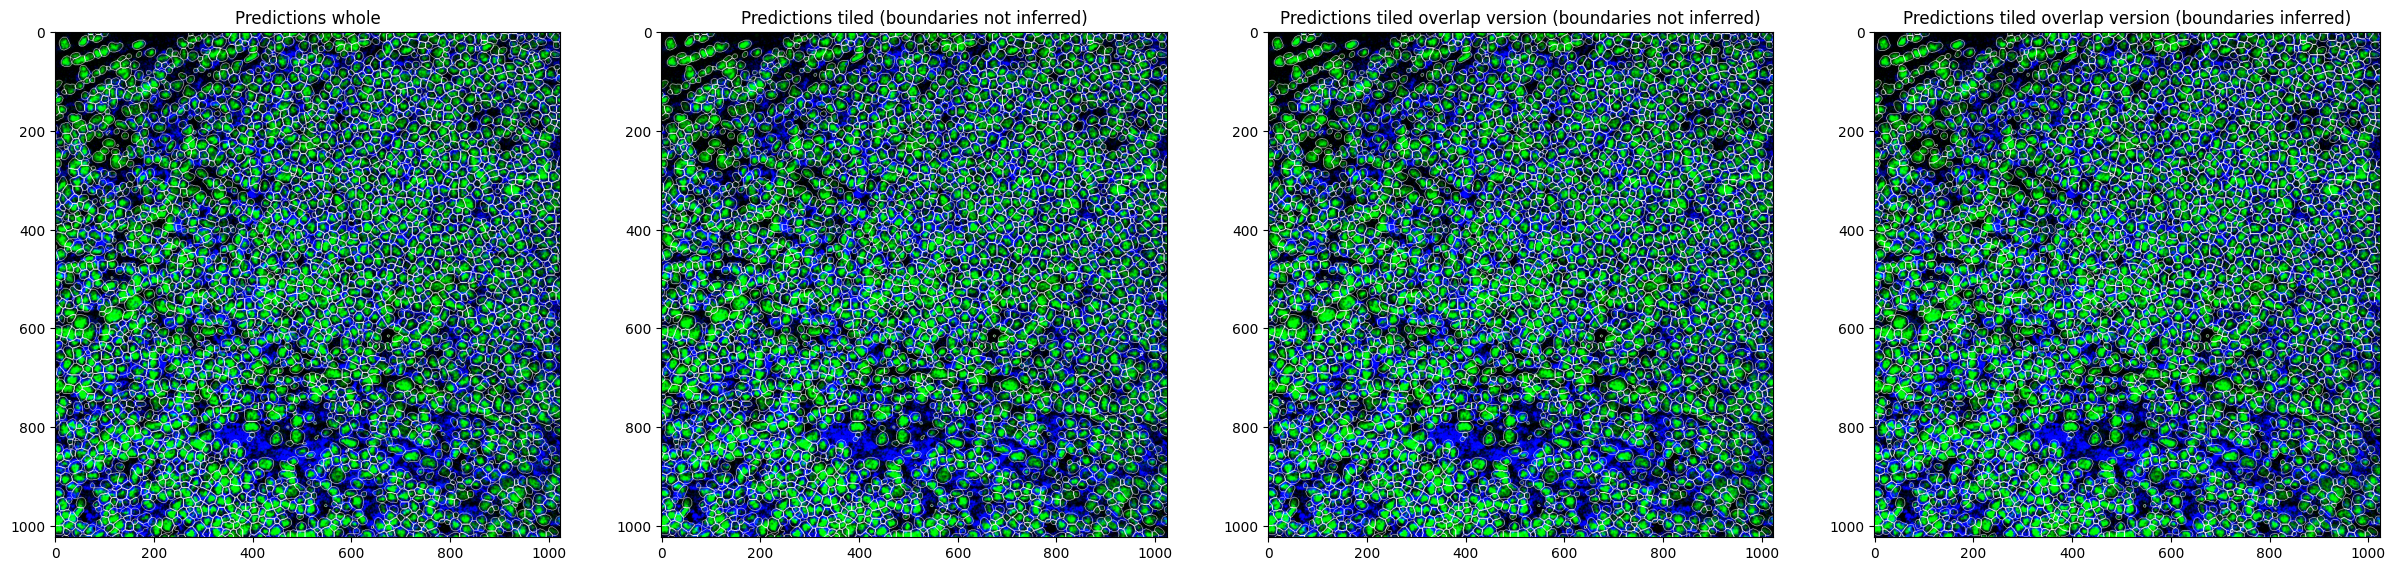

In [88]:
# select index for displaying
idx = 0

# plot the data
fig, ax = plt.subplots(1, 4 ,figsize=(30, 30))

ax[0].imshow(overlay_data[idx, ...])
ax[1].imshow(overlay_data_tile_pipeline_gaps[idx,...])
ax[2].imshow(overlay_data_tile_pipeline_gaps_overlap[idx, ...])
ax[3].imshow(overlay_data_tile_pipeline_no_gaps_overlap[idx, ...])

ax[0].set_title('Predictions whole')
ax[1].set_title('Predictions tiled (boundaries not inferred)')
ax[2].set_title('Predictions tiled overlap version (boundaries not inferred)')
ax[3].set_title('Predictions tiled overlap version (boundaries inferred)')

plt.show()

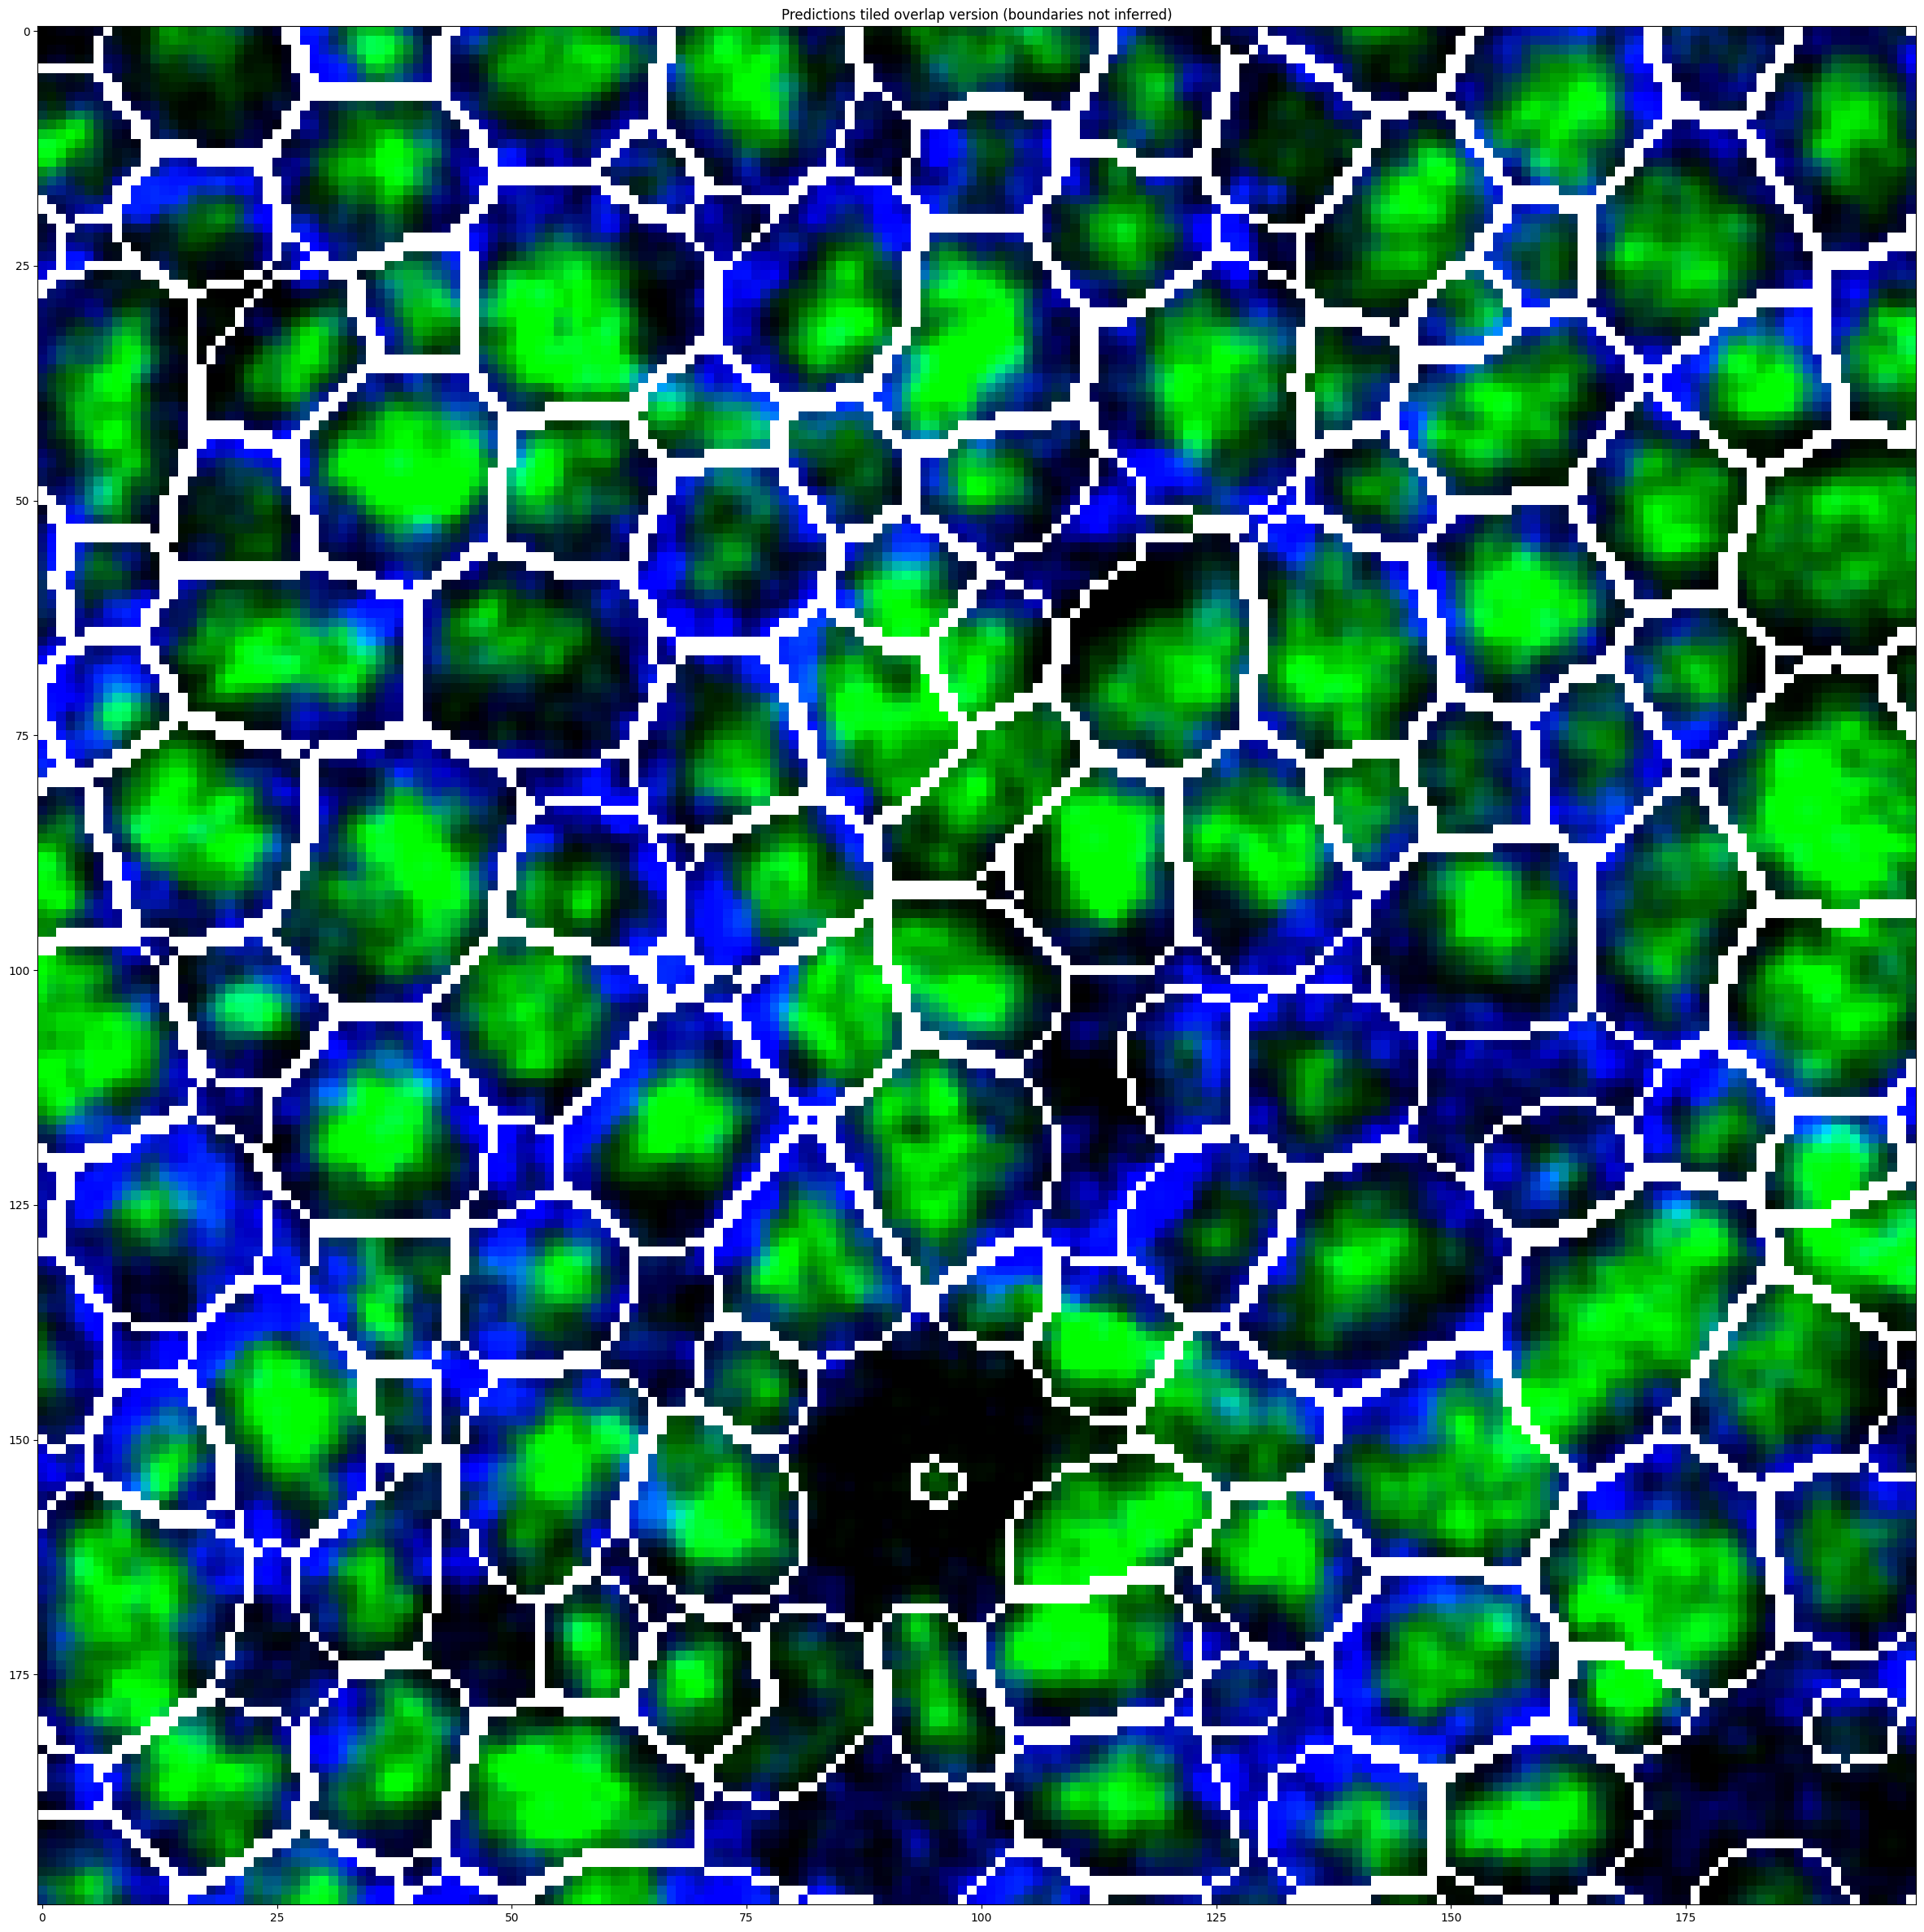

In [92]:
# select index for displaying
idx = 0

# plot the data
fig, ax = plt.subplots(1 ,figsize=(30, 30))

ax.imshow(overlay_data_tile_pipeline_gaps_overlap[idx, (tile_faster["row_tile_size"]-100):(tile_faster["row_tile_size"]+100) ,(tile_faster["col_tile_size"]-100):(tile_faster["col_tile_size"]+100), ...])


ax.set_title('Predictions tiled overlap version (boundaries not inferred)')

plt.show()

### Compare the different segmentation approaches

In [93]:
areas_whole = np.asarray([np.sum(segmentation_predictions_whole[0,:,:,:] == l) for l in np.unique(segmentation_predictions_whole[0,:,:,:])][1:])

In [94]:
areas_whole_gaps = np.asarray([np.sum(segmentation_predictions_whole_gaps[0,:,:,:] == l) for l in np.unique(segmentation_predictions_whole_gaps[0,:,:,:])][1:])

In [95]:
areas_overlap_false = np.asarray([np.sum(segmentation_predictions_whole_gaps_overlap_false[0,:,:,:] == l) for l in np.unique(segmentation_predictions_whole_gaps_overlap_false[0,:,:,:])][1:])

In [96]:
areas_overlap_true = np.asarray([np.sum(segmentation_predictions_whole_gaps_overlap_true[0,:,:,:] == l) for l in np.unique(segmentation_predictions_whole_gaps_overlap_true[0,:,:,:])][1:])

In [97]:
(areas_whole[areas_whole > 50]).shape

(2802,)

In [98]:
(areas_whole_gaps[areas_whole_gaps > 50]).shape

(2802,)

In [99]:
(areas_overlap_false[areas_overlap_false > 50]).shape

(2802,)

In [100]:
(areas_overlap_true[areas_overlap_true > 50]).shape

(2815,)

### Save and visualise segmentation output

In [81]:
save_model_output_wrapper(segmentation_predictions_whole_gaps, output_dir=deepcell_output_dir, feature_name=fovs[0],compartment="whole-cell")

# save the overlaid segmentation labels for each fov (these will not display, but will save in viz_dir)
segmentation_utils.save_segmentation_labels(
    segmentation_dir=deepcell_output_dir,
    data_dir=deepcell_input_dir,
    output_dir=deepcell_visualization_dir,
    fovs=io_utils.remove_file_extensions(fovs),
    channels=None
)

### Afterwards, we can generate expression matrices from the labeling + imaging data

In [83]:
# set to True to add nuclear cell properties to the expression matrix
nuclear_counts = False

# set to True to bypass expensive cell property calculations
# only cell label, size, and centroid will be extracted if True
fast_extraction = True

For a full list of features extracted, please refer to the cell table section of: https://ark-analysis.readthedocs.io/en/latest/_rtd/data_types.html

In [84]:
# now extract the segmented imaging data to create normalized and transformed expression matrices
# note that if you're loading your own dataset, please make sure all the imaging data is in the same folder
# with each fov given its own folder and all fovs having the same channels
cell_table_size_normalized, cell_table_arcsinh_transformed = \
    marker_quantification.generate_cell_table(segmentation_dir=deepcell_output_dir,
                                              tiff_dir=tiff_dir,
                                              img_sub_folder=None,
                                              fovs=fovs,
                                              batch_size=5,
                                              nuclear_counts=nuclear_counts,
                                              fast_extraction=fast_extraction)

extracting data from ATAPOX166R-3


In [85]:
# Set the compression level if desired, ZSTD compression can offer up to a 60-70% reduction in file size.
# NOTE: Compressed `csv` files cannot be opened in Excel. They must be uncompressed beforehand.
compression = None

# Uncomment the line below to allow for compressed `csv` files.
# compression = {"method": "zstd", "level": 3}

cell_table_size_normalized.to_csv(os.path.join(cell_table_dir, 'cell_table_size_normalized.csv'),
                                  compression=compression, index=False)
cell_table_arcsinh_transformed.to_csv(os.path.join(cell_table_dir, 'cell_table_arcsinh_transformed.csv'),
                                      compression=compression, index=False)

## Perform CellDIVE specific QC

### DAPI divergence and cell size

In [86]:
cell_table_size_normalized_qc = cell_table_size_normalized.loc[cell_table_size_normalized["cell_size"] > 50,]
cell_table_size_normalized_qc = cell_table_size_normalized_qc.loc[abs(cell_table_size_normalized_qc["DAPI_INIT"] - cell_table_size_normalized_qc["DAPI_FINAL"])/cell_table_size_normalized_qc["DAPI_INIT"] <= 0.5, ]

In [88]:
list_arcsinh_transformed_qc = []
# cell_table_arcsinh_transformed_qc = cell_table_arcsinh_transformed_qc.loc[[False for j in range(cell_table_arcsinh_transformed_qc.shape[0])], ]

for j in fovs:
    array_mask = np.isin(np.array(cell_table_arcsinh_transformed.loc[cell_table_arcsinh_transformed["fov"] == j, "label"]),  np.array(cell_table_size_normalized_qc.loc[cell_table_size_normalized_qc["fov"] == j, "label"]))
    
    df = pd.DataFrame.copy(cell_table_arcsinh_transformed)
    df = pd.DataFrame(df.loc[df["fov"] == j,].loc[array_mask,])
    list_arcsinh_transformed_qc.append(df,) 

cell_table_arcsinh_transformed_qc = pd.concat(list_arcsinh_transformed_qc)

In [89]:
all(cell_table_arcsinh_transformed_qc["label"] == cell_table_size_normalized_qc["label"])

True

In [90]:
compression = None
cell_table_size_normalized_qc.to_csv(os.path.join(cell_table_dir_qc, 'cell_table_size_normalized.csv'),
                                  compression=compression, index=False)
cell_table_arcsinh_transformed_qc.to_csv(os.path.join(cell_table_dir_qc, 'cell_table_arcsinh_transformed.csv'),
                                      compression=compression, index=False)